# Определение стоимости автомобилей

<p style='text-align: justify;'>Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.</p>

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<hr>
<div align='left'><b>Описание данных</b></div>

<ul> 
<li><b>DateCrawled </b> — дата скачивания анкеты из базы;</li>
<li><b>VehicleType </b> — тип автомобильного кузова;</li>
<li><b>RegistrationYear</b> — год регистрации автомобиля;</li>
<li><b>Gearbox</b> — тип коробки передач;</li>
<li><b>Power</b> —  мощность (л. с.);</li>
<li><b>Model</b> — модель автомобиля;</li>
<li><b>Kilometer</b> — пробег (км);</li>
<li><b>RegistrationMonth</b> — месяц регистрации автомобиля;</li>
<li><b>FuelType</b> — тип топлива;</li>
<li><b>Brand</b> — марка автомобиля;</li>
<li><b>Repaired</b> — была машина в ремонте или нет;</li>
<li><b>DateCreated</b> — дата создания анкеты;</li>
<li><b>NumberOfPictures</b> — количество фотографий автомобиля;</li>
<li><b>PostalCode</b> — почтовый индекс владельца анкеты (пользователя);</li>
<li><b>LastSeen</b> — дата последней активности пользователя;</li>
<li><b>Price</b> — цена (евро) - целевой признак;</li>
</ul>

<br><br>

<div align='left'><b>План работы</b></div>

1. [Загрузка данных](#step)
2. [Предобработка данных и EDA](#step_0)
3. [Подготовка данных](#step_1)
4. [Обучение моделей](#step_2)
5. [Анализ моделей](#step_3)
6. [Проверка на тестовой выборке](#step_4)
7. [Общий вывод](#step_5)

In [1]:
!pip install phik -q
!pip install category_encoders -q
!pip install lightgbm -q
!pip install catboost -q
!pip install shap -q

In [2]:
import math
import re
import csv
import warnings

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import phik
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, SCORERS, make_scorer
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import shap

In [3]:
RANDOM_STATE = 1
TEST_SIZE = 0.25

In [4]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

<a id='step'></a>

## Загрузка данных

In [5]:
def csv_download(file_name: str) -> pd.DataFrame:
    '''Accepts the name of the file(the file name is specified with the extension, 
    if the file does not lie in the folder with this notebook, 
    the full path should be specified). 
    Selects the delimiter and decimal separator for correct data reading.
    Returns the DataFrame object obtained from the file with the passed name.'''
    
    sniffer = csv.Sniffer()
    with open(file_name) as file:
        sample = file.read(5000)
        delimiter = sniffer.sniff(sample).delimiter
        
        file.seek(0)
        reader = csv.reader(file, delimiter=delimiter)
        decimal_counts = {'.': 0, ',': 0}
        for row in reader:
            for cell in row:
                if re.match(r'^\d+,\d+$', cell):
                    decimal_counts[','] += 1
                elif re.match(r'^\d+\.\d+$', cell):
                    decimal_counts['.'] += 1
        decimal_separator = max(decimal_counts, key=decimal_counts.get)
        
        file.seek(0)
        data = pd.read_csv(file, decimal=decimal_separator, delimiter=delimiter, parse_dates=True)
        
    return data

<hr>

Загрузим данные и ознакомимся с ними

<hr>

In [6]:
data = csv_download('/datasets/autos.csv')

In [7]:
display(data.head())
display(data.info())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были загружены данные. В получившемся фрйме содержится 354,369 строк и 16 столбцов. Данные соответствуют описанию. В столбцах <i>VehicleType</i>, <i>Gearbox</i>, <i>Model</i>, <i>FuelType</i> и <i>Repaired</i> присутствуют пропущенные значения, образовавшиеся, скорее всего, на этапе сбора информации. Данные представлены типами <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.</p>

<hr>

<a id='step_0'></a>

## Предобработка данных и EDA

In [8]:
def show_unique_values(frames: dict[str:pd.DataFrame], 
                       column_names: list[str], 
                       just_all_unique: bool=True) -> None:
    '''Display unique values from specified columns in given DataFrames.
    Does not return any value. It prints the results directly'''
    
    res = {}
    print()
    if not just_all_unique:
        for key, frame in frames.items():
            print(f'\033[92mУникальные значения в фрейме \033[1m{key}\033[0m\033[92m для столбца:\033[0m'.center(140))
            print('_'*120)
            for name in column_names:
                if name not in frame.columns:
                    continue
                res[name] = res.setdefault(name, set())
                res[name].update(frame[name].unique())
                print(f'\033[1m{name}\033[0m', sorted(frame[name].unique()), sep='\n', end='\n\n')
            print('_'*120, end='\n\n\n')
    else:
        for key, frame in frames.items():
            for name in column_names:
                if name not in frame.columns:
                    continue
                res[name] = res.setdefault(name, set())
                res[name].update(frame[name].unique())
            
    print(f'\033[92mВсе уникальные значения\033[0m'.center(140))
    for key, value in res.items():
        print(f'\033[1m{key}:\033[0m')
        print(*(s.rjust(len(s) + 4) for s in sorted(value)), sep='\n', end='\n\n')

In [9]:
def description(df: pd.DataFrame, column: str, ax: plt.Axes=None, 
               round_to: int = 3, cut_lim: bool = False, color_column: str = None,
               title: str = None, xlabel: str = None) -> None:
    '''Feature (column) description from DataFrame (df)'''
    
    if not ax:
        fig, ax = plt.subplots()
    if color_column:
        sns.boxplot(x=color_column, y=column, data=df, ax=ax)
    else:
        ax.boxplot(x=column, data=df)
        
    ax.grid()
    ax.set_title(title, 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    ax.set_xlabel(xlabel, 
                  weight='bold', 
                  size=12)
    stats = df[column].describe().round(round_to)
    legend_text = '\n'.join([f'{stat}: {value}' for stat, value in stats.items()])
    ax.legend([legend_text], loc='upper right', handlelength=0, fontsize=15)
    
    if cut_lim:
        q1 = np.quantile(df[column], 0.25)
        q3 = np.quantile(df[column], 0.75)
        iqr = q3 - q1
        ax.set_ylim((q1 - 1.6 * iqr, q3 + 1.6 * iqr))

In [10]:
def hist_plot(df: pd.DataFrame, column: str, 
              alpha: float=0.4, ax: plt.Axes=None, 
              bins: int = 10, color_column: str = None, order: bool=False, 
              xlabel: str = None, ylabel: str = None, title: str = None) -> None:
    '''Creating a histogram of a feature (column) from a DataFrame (df)'''
    
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    data = df.copy()
    if order:
        category_counts = data[column].value_counts()
        data[column] = pd.Categorical(data[column], categories=category_counts.index, ordered=True)
    
    if color_column:
        sns.histplot(data=data, 
                     x=column, 
                     hue=color_column, 
                     bins=bins, 
                     ax=ax, 
                     multiple='stack', 
                     alpha=alpha)
    else:
        df[column].plot(kind='hist', bins=bins, ax=ax)

    ax.grid()
    ax.set_xlabel(xlabel, 
                  weight='bold', 
                  size=12)
    ax.set_ylabel(ylabel, 
                  weight='bold', 
                  size=12)
    ax.set_title(title, 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)

In [11]:
def show_hists(df: pd.DataFrame, columns: list[str], color_column: str = None, 
               alpha: float=0.4, cat: bool=False, in_row: int=1,
               bins: int = 10, mask: dict[str]=dict()) -> None:
    '''Designed to display histograms and corresponding span charts 
    for a set of columns in the provided DataFrame.'''
    
    if not cat:
        fig, axes = plt.subplots(len(columns), 2, figsize=(16, len(columns) * 12))
    else:
        fig, axes = plt.subplots(math.ceil(len(columns) / in_row), in_row, 
                             figsize=(16, math.ceil(len(columns) / in_row) * 12))
        
    for i in range(len(columns)):
        xlabel = mask.setdefault(columns[i], 'Parameter')
        ylabel = 'Количество значений в выборке'
        title = f'Распределение параметра\n"{xlabel}" в выборке'
        if not cat:
            if len(columns) == 1:
                ax_hist = axes[0]
                ax_desc = axes[1]
            else:
                ax_hist = axes[(i), 0]
                ax_desc = axes[(i), 1]
            hist_plot(df=df, 
                      column=columns[i], 
                      ax=ax_hist, 
                      color_column=color_column,
                      xlabel=xlabel, 
                      ylabel=ylabel, 
                      title=title, 
                      bins=bins, 
                      order=cat)
            description(df=df, 
                        column=columns[i], 
                        ax=ax_desc, 
                        title='Соответсвующая диаграмма размаха', 
                        xlabel=xlabel, 
                        cut_lim=True)
        else:
            if len(columns) == 1:
                ax = axes
            elif in_row == 1:
                ax = axes[i]
            else:
                ax = axes[(i) // in_row, (i) % in_row]
            hist_plot(df=df, 
                      column=columns[i], 
                      ax=ax, 
                      color_column=color_column,
                      xlabel=xlabel, 
                      ylabel=ylabel, 
                      title=title, 
                      bins=bins, 
                      order=cat)

In [12]:
def cor_heatmap(df: pd.DataFrame, parameters: list[str], 
                kind: str = 'Spearman', n_round: int=2,
                figsize: tuple[int] = (10, 10)) -> None:
    '''Heatmap of the correlation matrix (df[parameters])'''
    
    if kind == 'Phik':
        types = df.dtypes.reset_index()
        types.columns = ['index', 'type']
        quantitive = list(types.loc[(types['type'] == 'int64') | (types['type'] == 'float64'), 'index'])
        data_corr = df[parameters].phik_matrix(quantitive)
    elif kind == 'Pearson':
        data_corr = df[parameters].corr()
    elif kind == 'Spearman':
        data_corr = df[parameters].corr(method='spearman')
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(data_corr, dtype=bool))
    sns.heatmap(data_corr, 
                annot=True, 
                cmap='coolwarm',
                mask=mask,
                fmt=f".{n_round}f", 
                vmin=-1, 
                vmax=1, 
                center=0) 
    plt.title(f'Матрица корреляций, использующая метод {kind}', 
                 weight='bold', 
                 size=15, 
                 color='darkred', 
                 pad=20)
    plt.show()

In [13]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

<hr>

Оформим название столбцов в соответствии с форматом snake_case. Обработаем пропущенные значения в датафрейме и проверим наличие дубликатов.

<hr>

In [14]:
data = data.rename(columns=lambda x: re.sub(r'(?<!^)([A-Z])', r'_\1', x).lower())   

<hr>

Столбцы, содержащие пропуски:
 - VehicleType — тип автомобильного кузова; 
 - Gearbox — тип коробки передач;
 - Model — модель автомобиля;
 - FuelType — тип топлива;
 - Repaired — была машина в ремонте или нет;

Выведем все сроки и столбцы, в которых содержатся пропуски.

<hr>

In [15]:
null_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
display(data.loc[data[null_columns].isna().any(axis=1), null_columns].head())
data.loc[data['model'].isna(), :].shape[0]

,vehicle_type,gearbox,model,fuel_type,repaired
0,NaN,manual,golf,petrol,NaN
1,coupe,manual,NaN,gasoline,yes
2,suv,auto,grand,gasoline,NaN
8,bus,manual,c_max,petrol,NaN
9,small,manual,golf,NaN,NaN


19705

<hr>

<p style='text-align: justify;'>Присутствуют 19705 строчек, в которых отсутствуют данные о модели машины, уберем из датафрейма такие строчки, так как восстановить их не получится. <br><br>Значения в столбце "Repaired" восстановить по другим данным невозможно, поэтому заменим пропуски значением "unknown". <br><br>Соберем агрегированную таблицу, где для каждой уникальной модели машины будет указан наиболее часто встречающийся тип кузова, тип коробки передач и тип используемого топлива, по этой таблице будем восстанавливать пропущенные значения в соответствующих столбцах.</p>

<hr>

In [16]:
full_data = data.copy()

In [17]:
data = data.loc[~data['model'].isna(), :]
data.loc[data['repaired'].isna(), 'repaired'] = 'unknown'
data.shape

(334664, 16)

In [18]:
agg_table = data.groupby('model').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

for col in ['vehicle_type', 'gearbox', 'fuel_type']:
    data[col] = data.groupby('model')[col].transform(lambda x: x.fillna(agg_table[col][x.name]))

In [19]:
data.loc[data[null_columns].isna().any(axis=1), null_columns].shape[0]

0

<hr>

Посмотрим, есть ли неявные дубликаты в данных.

<hr>

In [20]:
cat_columns = ['vehicle_type', 
               'gearbox', 
               'model', 
               'fuel_type', 
               'brand', 
               'repaired']
frames = {'data':data}
show_unique_values(frames, cat_columns, just_all_unique=True)


                                                      Все уникальные значения                                                      
vehicle_type:
    bus
    convertible
    coupe
    other
    sedan
    small
    suv
    wagon

gearbox:
    auto
    manual

model:
    100
    145
    147
    156
    159
    1_reihe
    1er
    200
    2_reihe
    300c
    3_reihe
    3er
    4_reihe
    500
    5_reihe
    5er
    601
    6_reihe
    6er
    7er
    80
    850
    90
    900
    9000
    911
    a1
    a2
    a3
    a4
    a5
    a6
    a8
    a_klasse
    accord
    agila
    alhambra
    almera
    altea
    amarok
    antara
    arosa
    astra
    auris
    avensis
    aveo
    aygo
    b_klasse
    b_max
    beetle
    berlingo
    bora
    boxster
    bravo
    c1
    c2
    c3
    c4
    c5
    c_klasse
    c_max
    c_reihe
    caddy
    calibra
    captiva
    carisma
    carnival
    cayenne
    cc
    ceed
    charade
    cherokee
    citigo
    civic
    cl
    clio
    c

<hr>

В типе топлива присутствуют <i>petrol</i> и <i>gasoline</i>, которые являются "бензином", поэтому заменим все значения <i>gasoline</i> на <i>petrol</i>.

Приведем столбцы <i>date_crawled</i> ,<i>date_created</i> и <i>last_seen</i> к типу данных <i><font color='purple'>datetime</font></i>

<hr>

In [21]:
data['fuel_type'].replace('gasoline', 'petrol', inplace=True)

In [22]:
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334664 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        334664 non-null  datetime64[ns]
 1   price               334664 non-null  int64         
 2   vehicle_type        334664 non-null  object        
 3   registration_year   334664 non-null  int64         
 4   gearbox             334664 non-null  object        
 5   power               334664 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           334664 non-null  int64         
 8   registration_month  334664 non-null  int64         
 9   fuel_type           334664 non-null  object        
 10  brand               334664 non-null  object        
 11  repaired            334664 non-null  object        
 12  date_created        334664 non-null  datetime64[ns]
 13  number_of_pictures  334664 no

<hr>

<p style='text-align: justify;'>Теперь посмотрим на распределение значений в каждом столбце. Для количественных данных также выведем диаграмму размаха. <br><br>Цветом в диаграммах выделим зависимость от целевого признака. Для этого посмотрим числовое описание значений целевого признака и сформируем диапазоны цен, каждый диапазон отобразим на графиках отдельным цветом.</p>

<hr>

In [24]:
data['price'].describe()

count    334664.000000
mean       4504.346790
std        4531.438572
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

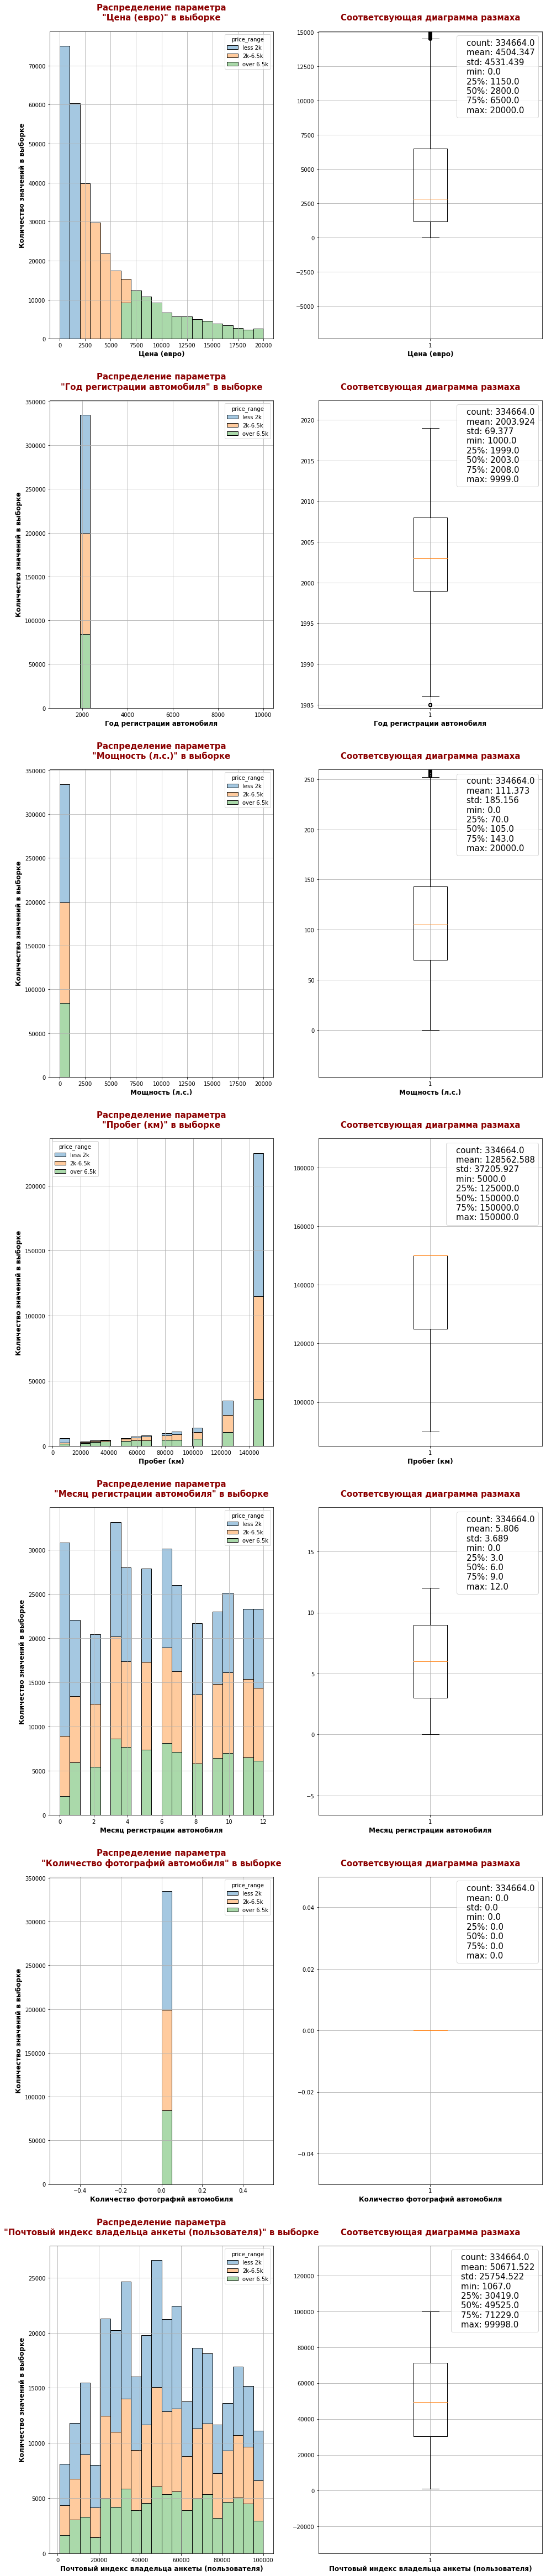

In [25]:
num_params = ['price', 
              'registration_year', 
              'power', 
              'kilometer', 
              'registration_month', 
              'number_of_pictures', 
              'postal_code']

num_mask = {'price':'Цена (евро)', 
            'registration_year':'Год регистрации автомобиля', 
            'power':'Мощность (л.с.)', 
            'kilometer':'Пробег (км)', 
            'registration_month':'Месяц регистрации автомобиля',  
            'number_of_pictures':'Количество фотографий автомобиля',  
            'postal_code':'Почтовый индекс владельца анкеты (пользователя)'}

bins = [0, 2000, 6500, 20001]
labels = ['less 2k', '2k-6.5k', 'over 6.5k']
analize_data = data.copy()
analize_data['price_range'] = pd.cut(analize_data['price'], 
                                     bins=bins, 
                                     labels=labels, 
                                     right=False, 
                                     include_lowest=True)


show_hists(df=analize_data,
           columns=num_params, 
           mask=num_mask, 
           bins=20,
           color_column='price_range',
           alpha=0.3)


<hr>

<p style='text-align: justify;'>По графикам распределения можно сказать, что в выборке большая часть машин продается за небольшую стоимость. График имеет гиперболический вид.<br><br>
В столбце с годом регистрации автомобиля присутствуют аномальные значения "9999" или "1000", они могли возникнуть в процессе некорректного заполнения даты, уберем строки со сзнаечнием года регистрации больше года выгрузки (2016) и меньше 1940 года.<br><br>
В столбце с мощностью также присутствуют аномальные значения до 20,000 лошадиных сил. Согласно информации из интернета, максимальная мощность машин в лошадиных силах доходит до значения 5,000, стоимость такого автомобиля сильно больше 20,000 евро (максимальная стоимость в выборке), уберем строки со значениями мощность больше 1000 л.с., а также с мощностью равной 0.<br><br>
Параметр "месяц регистрации автомобиля" принимает значение 0, оставим строки с этими значениями без изменений, потому что этот признак не будет включен в обучающий набор.<br><br>
В выборке все значения параметра "количество фотографий автомобиля" равны нулю, этот признак является неинформативным, поэтому также не будет использоваться для обучения.<br><br>
Параметр "почтовый индекс владельца анкеты" может косвено указывать на город, в котором продается автомобиль, но это не должно влиять на формирование цены.</p>

<hr>

In [26]:
data = data.loc[(data['registration_year'] <= 2016) & 
                (data['registration_year'] >= 1940) &
                (data['power'] < 1000) & 
                (data['power'] != 0), :]
data.shape[0]

290983

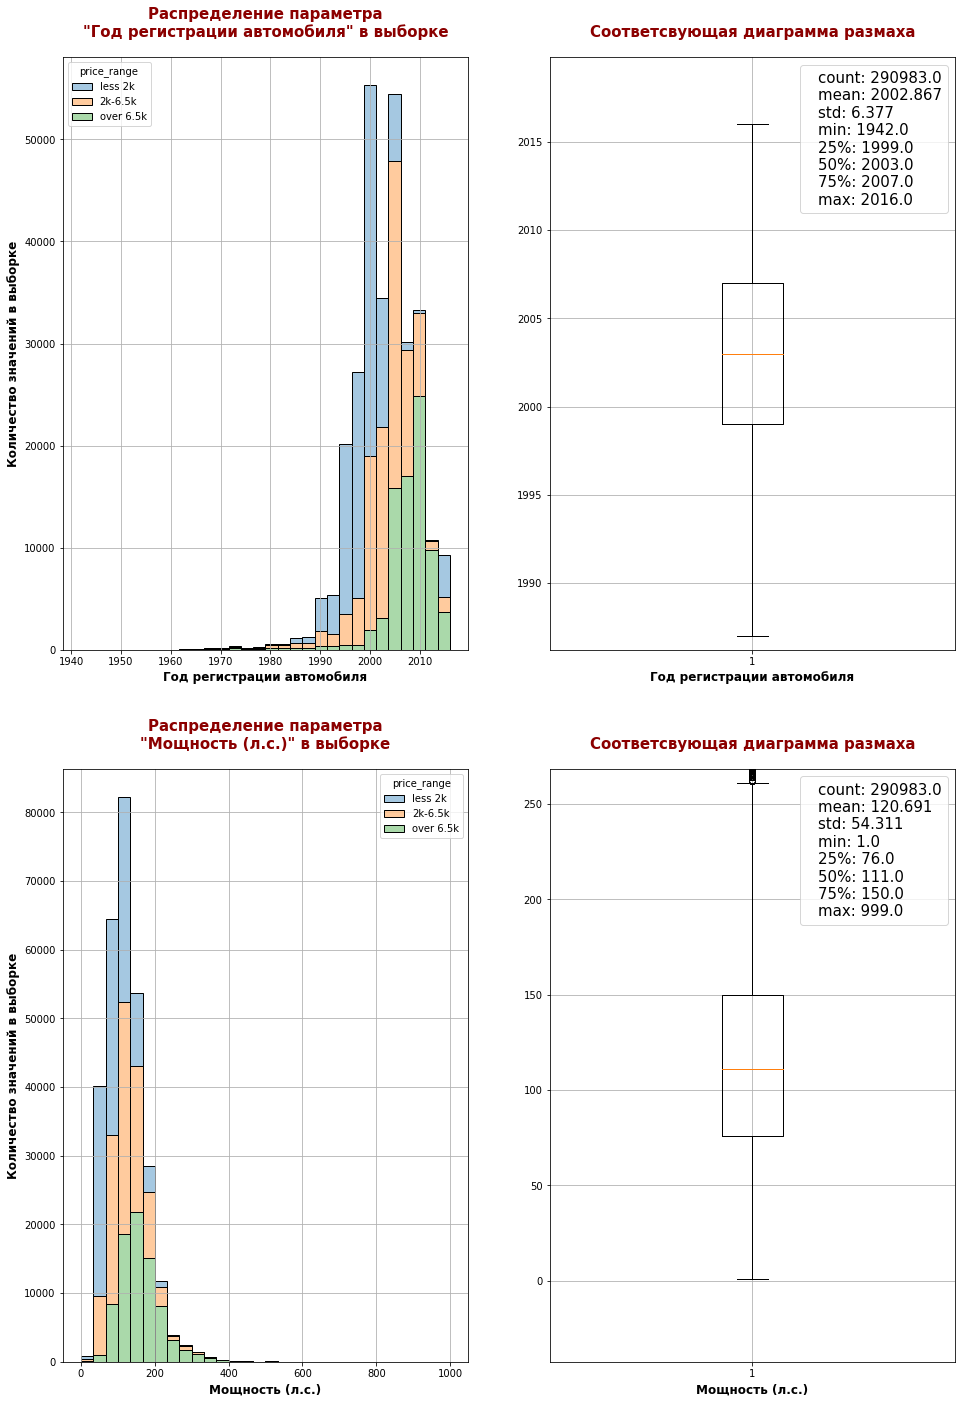

In [27]:
analize_data = data.copy()
analize_data['price_range'] = pd.cut(analize_data['price'], 
                                     bins=bins, 
                                     labels=labels, 
                                     right=False, 
                                     include_lowest=True)


show_hists(df=analize_data,
           columns=['registration_year', 'power'], 
           mask=num_mask, 
           bins=30,
           color_column='price_range',
           alpha=0.3)

<hr>

<p style='text-align: justify;'>По графикам можно сказать следующее:<br><br>Большинство машин стоимостью 2 тысячи и менее были зарегистрированы до 2005 года, часть "дешевых" машин было зарегистрировано после 2015 года. В промежуток 2005 - 2015 регистрировались в основном машины стоимостью от 2 тысяч евро.<br><br>
Машины с мощностью более 200 лошадиных сил стоят в основном более 6.5 тысяч евро.<br><br>Оба графика имеют вид нормального распределения.</p>

<hr>

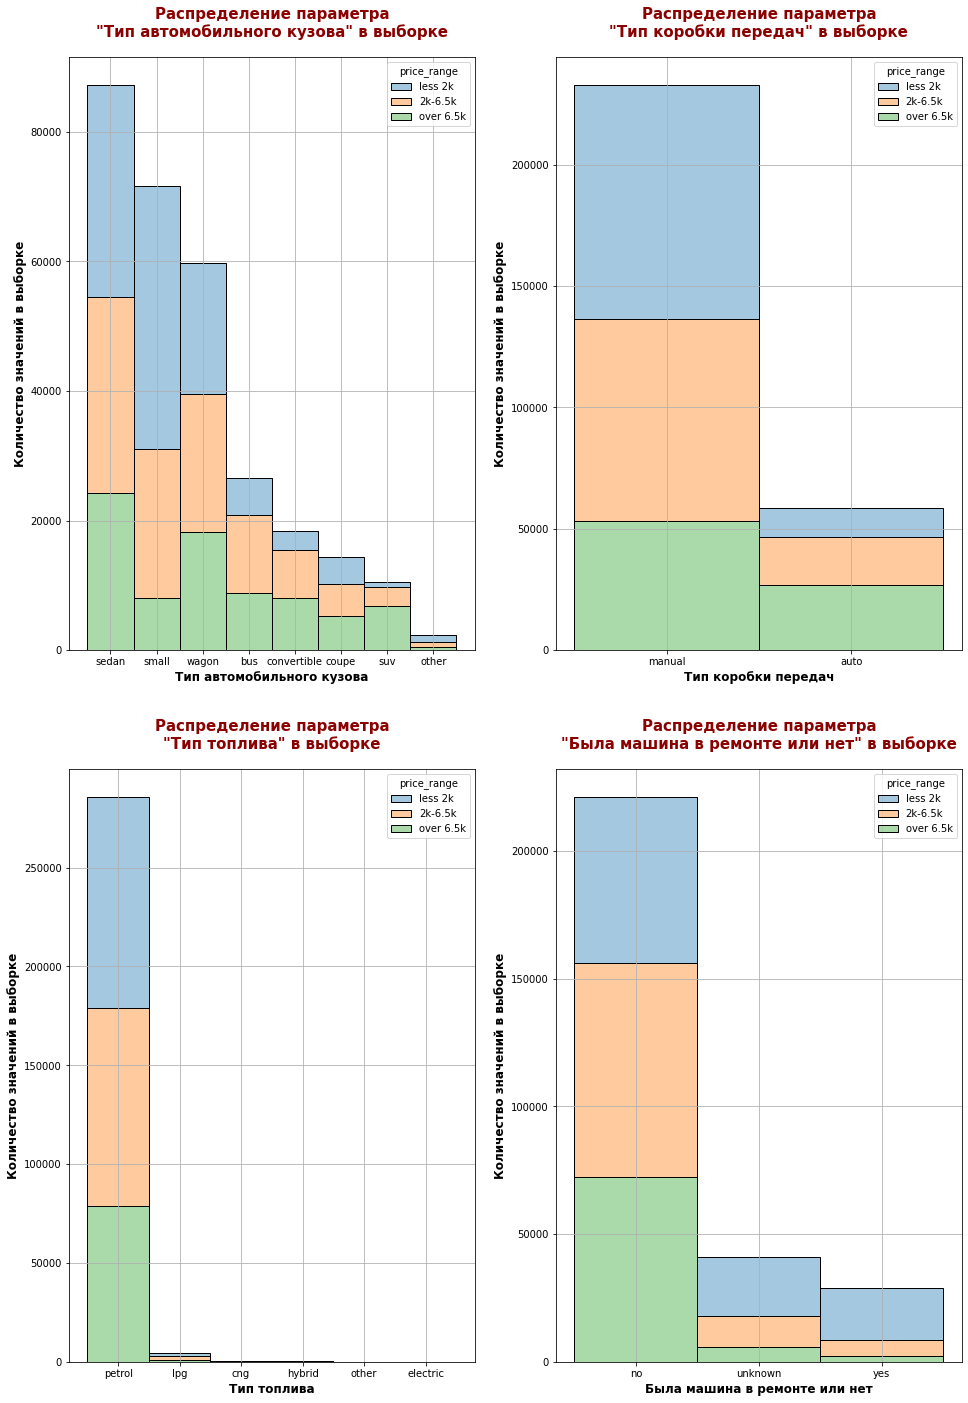

In [28]:
cat_params = ['vehicle_type', 
              'gearbox', 
              'fuel_type', 
              'repaired']

cat_mask = {'vehicle_type':'Тип автомобильного кузова', 
            'gearbox':'Тип коробки передач', 
            'fuel_type':'Тип топлива', 
            'repaired':'Была машина в ремонте или нет'}

show_hists(df=analize_data,
           columns=cat_params, 
           mask=cat_mask,
           color_column='price_range',
           cat=True,
           in_row=2,
           alpha=0.3)

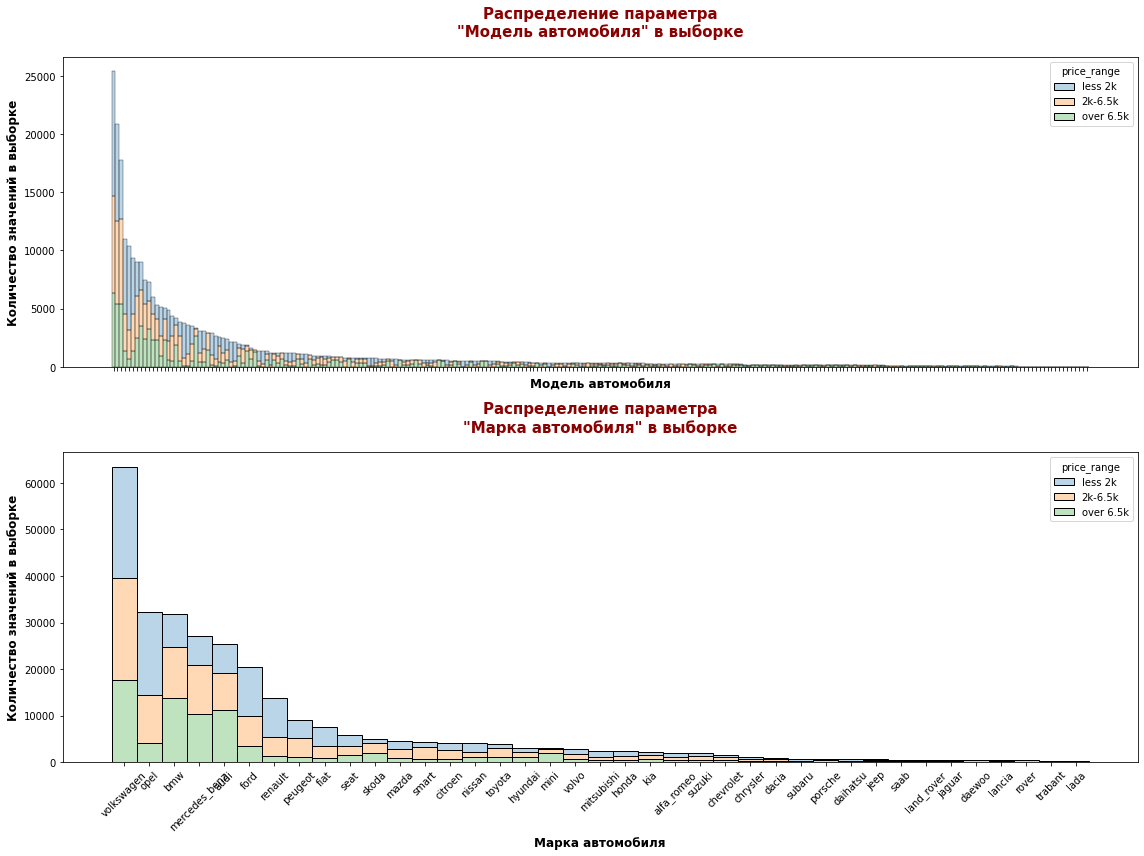

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
analize_data['model'] = pd.Categorical(analize_data['model'], 
                                       categories=analize_data['model'].value_counts().index, 
                                       ordered=True)

sns.histplot(data=analize_data, 
             x='model', 
             hue='price_range',
             ax=axes[0], 
             multiple='stack', 
             alpha=0.3)

axes[0].set_xlabel('Модель автомобиля', 
                   weight='bold', 
                   size=12)
axes[0].set_ylabel('Количество значений в выборке', 
                   weight='bold', 
                   size=12)
axes[0].set_title('Распределение параметра\n"Модель автомобиля" в выборке', 
                  weight='bold', 
                  size=15, 
                  color='darkred', 
                  pad=20)
axes[0].set_xticklabels('')

analize_data['brand'] = pd.Categorical(analize_data['brand'], 
                                       categories=analize_data['brand'].value_counts().index, 
                                       ordered=True)

sns.histplot(data=analize_data, 
             x='brand', 
             hue='price_range',
             ax=axes[1], 
             multiple='stack', 
             alpha=0.3)

axes[1].set_xlabel('Марка автомобиля', 
                   weight='bold', 
                   size=12)
axes[1].set_ylabel('Количество значений в выборке', 
                   weight='bold', 
                   size=12)
axes[1].set_title('Распределение параметра\n"Марка автомобиля" в выборке', 
                  weight='bold', 
                  size=15, 
                  color='darkred', 
                  pad=20)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

<hr>

Явной зависимости целевого признака от категориальных параметров по графикам не наблюдается.

Построим матрицу корреляций.

<hr>

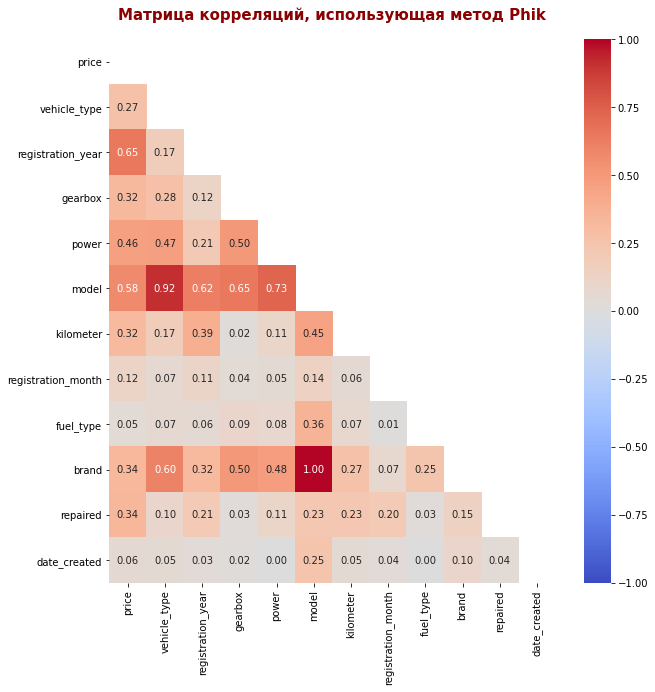

In [30]:
cor_heatmap(data, 
            data.columns.drop(['date_crawled', 'number_of_pictures', 'last_seen', 'postal_code']), 
            kind='Phik')

<hr>

Коэффициенты корреляции между парамтерами <i>model</i> и <i>brand</i>, а также между <i>model</i> и <i>vehicle_type</i> превышают 0.9, это говорит о мультиколлинеарноси. Объединим значения <i>model</i>, <i>vehicle_type</i> и <i>brand</i> в один признак.

Преобразуем признак <i>date_created</i> в числовой формат - количество дней, прошедших с 1 января 2000 года, для дальнейшей работы модели с этим параметром.

После изменений выведем обновленную матрицу корреляции с параметрами, которые планируется использовать при обучении.

<hr>

In [31]:
data['brand_model_vehicle'] = data['brand'] + ' ' + data['model'] + ' ' + data['vehicle_type']
data['creation_day'] = (data['date_created'] - pd.Timestamp("2000-01-01")) // pd.Timedelta('1D')

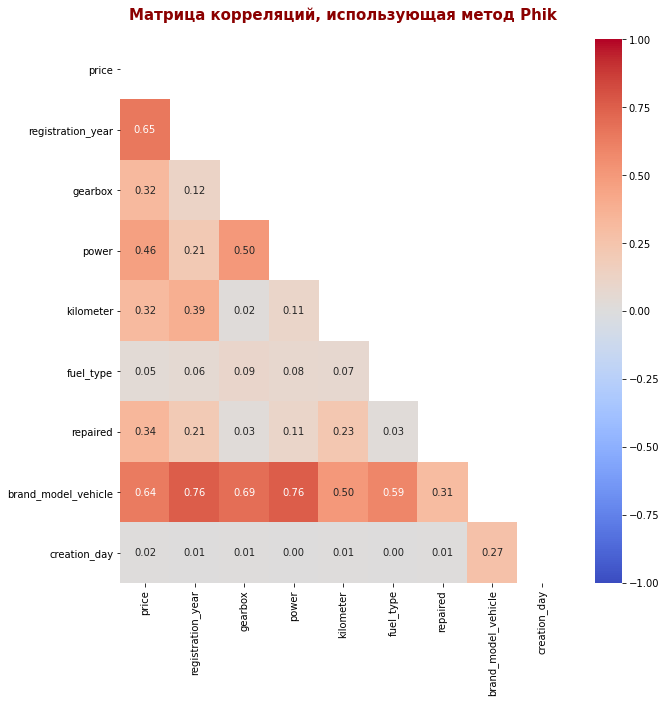

In [32]:
cor_heatmap(data, 
            ['price', 'registration_year', 
             'gearbox', 'power', 'kilometer', 'fuel_type', 
             'repaired', 'brand_model_vehicle', 'creation_day'], 
            kind='Phik')

<hr>

Приведем числовые типы данных к типам данных меньшего размера для большей экономии памяти и ускорения работы с данными.

<hr>

In [33]:
data = optimize_memory_usage(data)

Размер использования памяти: до 42.18 Mb - после 29.42 Mb (30.3%)


<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе была проведена предобработка данных.<br><br>
Были изменены названия столбцов в соответствии с форматом snake_case. Столбцы с информацией о датах были приведены к типу данных <i>datetime.</i><br><br>
Часть пропущенных значений в столбцах <i>vehicle_type</i>, <i>gearbox</i> и <i>fuel_type</i> была восстановленна по наиболее часто встречающимся значениям для соответствующей модели автомобиля, строки с пропусками в столбцах <i>repaired</i> и <i>model</i> были удалены.<br><br>
В типе топлива присутствовали значения <i>petrol</i> и <i>gasoline</i>, которые являются "бензином", они были приведены к одному значению <i>petrol</i>.<br><br>
Для категориальных и количественных параметров были построенны диаграммы размаха, на них также была отображена зависимость целевого признака. По построенным графикам были сделаны следующие выводы:</p>

<p style='text-align: justify;'> - В выборке большая часть машин продается за небольшую стоимость. График распределения стоимости имеет гиперболический вид.<br>
 - Большинство машин стоимостью 2 тысячи и менее были зарегистрированы до 2005 года, часть "дешевых" машин было зарегистрировано после 2015 года. В промежуток 2005 - 2015 регистрировались в основном машины стоимостью от 2 тысяч евро. График имеет вид нормального распределения.<br>
 - Машины с мощностью более 200 лошадиных сил стоят в основном более 6.5 тысяч евро. График имеет вид нормального распределения.<br>
 - Параметр "месяц регистрации автомобиля" принимает значение 0, эта ошибка была оставлена без изменений, потому что данный признак не будет учавствовать в обучении.<br>
 - В выборке все значения параметра "количество фотографий автомобиля" равны нулю, этот признак является неинформативным.<br>
 - Параметр "почтовый индекс владельца анкеты" может косвено указывать на город, в котором продается автомобиль, но это не должно влиять на формирование цены.<br>
 - Явной зависимости целевого признака от категориальных параметров <u>по графикам</u> не наблюдается.</p>
 
<p style='text-align: justify;'>В процессе построения графиков, была удалена часть строк с аномальными значениями параметров.</p>

<p style='text-align: justify;'>Далее была построена матрица корреляции Фи, по коэффициентам корреляции была обнаружена мультиколлиниарность. Для ее устранения признаки <i>model</i>, <i>vehicle_type</i> и <i>brand</i> были объединены в один признак <i>brand_model_vehicle</i>. Также был добавлен признак <i>creation_day</i>, в котором содержится информация о количестве дней, прошедших с 1 января 2000 года до момента выставления объявления о продаже, таким образом признак <i>date_created</i> был приведен к числовому типу данных.<br><br>По матрице не наблюдается корреляция между целевым признаком и новым признаком <i>creation_day</i>, но этот признак был сохранен для обучения с поправкой на текущую экономическую ситуацию, в 2015-2016 разница в стоимости одного и того же автомобиля, возможно, была не большой, но, например, в 2021-2022 годах, эта разница уже была существенной.<br><br>Столбцы с числовыми данными были приведены к типу данных меньшего размера для ускорения работы с данными.</p>

Для обучения будут использоваться следующие признаки:

 - <b>registration_year</b> - год регистрации автомобиля;
 - <b>gearbox</b> - тип коробки передач;
 - <b>power</b> - мощность (л. с.);
 - <b>kilometer</b> - пробег (км);
 - <b>fuel_type</b> - тип топлива;
 - <b>repaired</b> - была машина в ремонте или нет;
 - <b>brand_model_vehicle</b> - информация о марке, модели и типе кузова автомобиля;
 - <b>creation_day</b> - количество дней с 1 января 2000 года до дня, когда объявление о продаже было выставлено;

<hr>

<a id='step_1'></a>

## Подготовка данных

In [34]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [35]:
data = data.reset_index(drop=True)

In [36]:
cat_columns = ['gearbox', 'fuel_type', 'repaired', 'brand_model_vehicle']
num_columns = ['registration_year', 'power', 'kilometer', 'creation_day']


X_train, X_test, y_train, y_test = train_test_split(data[cat_columns + num_columns], data['price'], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

X_train[cat_columns] = X_train[cat_columns].astype('category')
X_test[cat_columns] = X_test[cat_columns].astype('category')

In [37]:
cat_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', OrdinalEncoder(handle_unknown='ignore')),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])


data_preprocessor = ColumnTransformer([('ord', cat_pipe, cat_columns)], 
                                       remainder='passthrough')

pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))])

In [38]:
params_dtr = {'models':[DecisionTreeRegressor(random_state=RANDOM_STATE)],
              'models__max_depth':range(2, 50), 
              'models__max_features':range(2, 50)}

params_lgbm = {'preprocessor':[None],
               'models':[lgb.LGBMRegressor(random_state=RANDOM_STATE, 
                                           learning_rate=0.05, 
                                           n_estimators=600)],
               'models__max_depth':range(2, 50), 
               'models__num_leaves':range(2, 50)}

params_ctb = {'preprocessor':[None], 
              'models':[CatBoostRegressor(random_state=RANDOM_STATE, cat_features=cat_columns, verbose=0)],
              'models__max_depth':range(2, 50), 
              'models__n_estimators':range(30, 300)}

In [39]:
scorer = make_scorer(rmse, greater_is_better=False)

randomized_search_dtr = RandomizedSearchCV(pipe_final, 
                                           params_dtr, 
                                           cv=5,
                                           scoring=scorer,
                                           random_state=RANDOM_STATE,
                                           n_jobs=-1, 
                                           n_iter=5, 
                                           verbose=1)

randomized_search_lgbm = RandomizedSearchCV(pipe_final, 
                                            params_lgbm, 
                                            cv=5,
                                            scoring=scorer,
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1, 
                                            n_iter=5, 
                                            verbose=1)

randomized_search_ctb = RandomizedSearchCV(pipe_final, 
                                           params_ctb, 
                                           cv=5,
                                           scoring=scorer,
                                           random_state=RANDOM_STATE,
                                           n_jobs=-1, 
                                           n_iter=5, 
                                           verbose=-1)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были подготовленны данные для дальнейшего обучения моделей.<br><br>Данные разбиты на тренировочную и тестовую выборки в соотношении 75/25.<br><br> <i>Для модели DecisionTreeRegressor:<br></i>Создан пайплайн для кодирования категориальных признаков с помощью кодировщика <i>OrdinalEncoder</i>. Собран полный пайплайн для выполнения обработки значений и передачи их в модели.<br><br><i>Для моделей CatBoostRegressor и LGBMRegressor:</i><br>Обработка категориальных данных производится с помощью встроенных инструментов в модели.<br><br>Определена метрика RMSE, которая будет определять качество моделей при обучении и итоговое качество модели. Для каждой модели определен объект кросс-валидации <i>RandomizedSearchCV</i> с помощью которого будут обучаться модели.</p>

<hr>

<a id='step_2'></a>

## Обучение моделей

In [40]:
%%time

_ = randomized_search_dtr.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 14.2 s, sys: 0 ns, total: 14.2 s
Wall time: 14.2 s


In [41]:
%%time

predictions_dtr = randomized_search_dtr.predict(X_test)

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 152 ms


In [42]:
print(f'Лучшая метрика RMSE при валидации: {-randomized_search_dtr.best_score_:.1f}')

Лучшая метрика RMSE при валидации: 2264.2


In [43]:
%%time

_ = randomized_search_lgbm.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 9min 49s, sys: 2.4 s, total: 9min 51s
Wall time: 10min


In [44]:
%%time

predictions_lgbm = randomized_search_lgbm.predict(X_test)

CPU times: user 7.09 s, sys: 6.1 ms, total: 7.09 s
Wall time: 7.11 s


In [45]:
print(f'Лучшая метрика RMSE при валидации: {-randomized_search_lgbm.best_score_:.1f}')

Лучшая метрика RMSE при валидации: 1653.2


In [46]:
%%time

_ = randomized_search_ctb.fit(X_train, y_train);

CPU times: user 1min 28s, sys: 594 ms, total: 1min 29s
Wall time: 1min 35s


In [47]:
%%time

predictions_ctb = randomized_search_ctb.predict(X_test)

CPU times: user 48.1 ms, sys: 0 ns, total: 48.1 ms
Wall time: 46.4 ms


In [48]:
print(f'Лучшая метрика RMSE при валидации: {-randomized_search_ctb.best_score_:.1f}')

Лучшая метрика RMSE при валидации: 1871.7


<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>В данном разделе были обучены 3 модели с метрикой <i>RMSE</i> при валидации:</p>

 - <b>DecisionTreeRegressor</b> - 2264.2;
 - <b>LGBMRegressor</b> - 1653.2;
 - <b>CatBoostRegressor</b> - 1871.7;
 
Модели были обучены с помощью <i>RandomizedSearchCV</i>.

<hr>

<a id='step_3'></a>

## Анализ моделей

In [49]:
def residuals_analysis(y_test: pd.DataFrame, predictions: np.ndarray, 
                       figsize: tuple[int]=(16, 8), 
                       title_size: int=18, xy_labels_size: int=12) -> pd.DataFrame:
    '''Construction of residuals histogram and scatter plot '''
    
        
    residuals = y_test - predictions
    
    fig = plt.figure(figsize=figsize)
    
    
    fig.add_subplot(1, 2, 1)
    plt.hist(residuals, bins=50)
    plt.title('Гистограмма распределения остатков', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.grid()
    
    
    fig.add_subplot(1, 2, 2)
    plt.scatter(predictions, 
                residuals, 
                alpha=0.3)
    plt.title('Анализ дисперсии', 
              size=title_size, 
              weight='bold',
              color='DarkRed')
    plt.xlabel('Предсказания модели', 
               size=xy_labels_size, 
               weight='bold')
    plt.ylabel('Остатки', 
               size=xy_labels_size, 
               weight='bold')
    plt.grid()
    
    
    plt.show()
    return residuals


                           Анализ остатков модели DecisionTreeRegressor                          


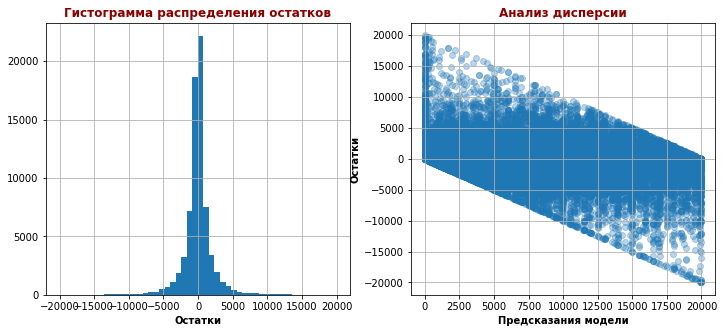

In [50]:
print('\n', '\033[1mАнализ остатков модели DecisionTreeRegressor'.center(100))
residuals_dtr = residuals_analysis(y_test=y_test, 
                                   predictions=predictions_dtr, 
                                   figsize=(12, 5), 
                                   title_size=12, 
                                   xy_labels_size=10)


                               Анализ остатков модели LGBMRegressor                              


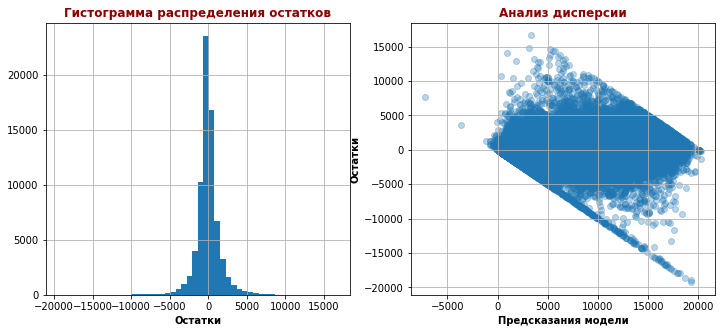

In [51]:
print('\n', '\033[1mАнализ остатков модели LGBMRegressor'.center(100))
residuals_dtr = residuals_analysis(y_test=y_test, 
                                   predictions=predictions_lgbm, 
                                   figsize=(12, 5), 
                                   title_size=12, 
                                   xy_labels_size=10)


                             Анализ остатков модели CatBoostRegressor                            


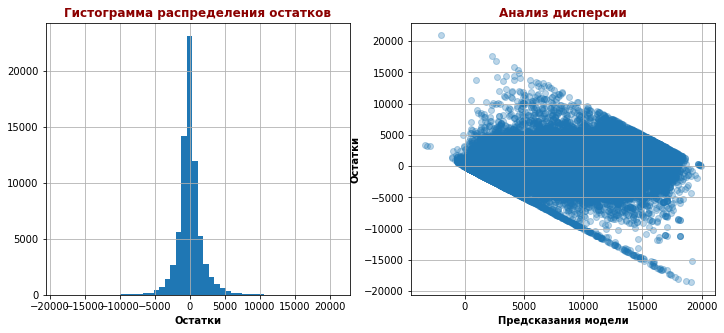

In [52]:
print('\n', '\033[1mАнализ остатков модели CatBoostRegressor'.center(100))
residuals_dtr = residuals_analysis(y_test=y_test, 
                                   predictions=predictions_ctb, 
                                   figsize=(12, 5), 
                                   title_size=12, 
                                   xy_labels_size=10)

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Для каждой модели был проведен анализ остатков, в результате которого было выявлено:</p>

 - Распределение остатков всех моделей не смещены относительно нуля, значит модель в среднем не завышает и не занижает стоимость. 
 - По дисперсии модели DecisionTreeRegressor можно сказать, что при низких значениях предсказанной стоимости, модель занижает ее значение, а при высоких значениях предсказанной стоимости, модель завышает ее. 
 - По дисперсии моделей LGBMRegressor и CatBoostRegressor можно сказать, что модели также занижают значения при низкой предсказанной стоимости и завышают при высокой, но при этом влияние ошибок меньше чем у модели DecisionTreeRegressor.
 
 
Характеристики модели <b>DecisionTreeRegressor</b>:
<br>Время обучения модели: ~20 секунд;
<br>Время предсказания модели: ~200 млс;
<br>Качество при валидации: 2264.2;

Характеристики модели <b>LGBMRegressor</b>:
<br>Время обучения модели: ~10 минут;
<br>Время предсказания модели: ~7 с;
<br>Качество при валидации: 1653.2;

Характеристики модели <b>CatBoostRegressor</b>:
<br>Время обучения модели: ~1 минута 30 секунд;
<br>Время предсказания модели: ~50 млс;
<br>Качество при валидации: 1871.0;

<p style='text-align: justify;'>По критериям: качество предсказания, время обучения модели и время предсказания модели, лучшей моделью является <b>CatBoostRegressor</b>, т.к. она сочетает низкоевремя обчуения и предсказания при достаточно высоком качестве. Будем использовать ее для предсказания на тестовой выборке. Все модели соответствуют требованию: "Значение метрики RMSE должно быть меньше 2500".</p>
 


<hr>

<a id='step_4'></a>

## Проверка на тестовой выборке

In [53]:
rmse_ctb = mean_squared_error(y_test, 
                              predictions_ctb, 
                              squared=False)

print(f'RMSE модели CatBoostRegressor на тестовых данных: {rmse_ctb:.1f}')

RMSE модели CatBoostRegressor на тестовых данных: 1853.6


<hr>

Построим графики важности с помощью метода <b>SHAP</b>.

<hr>

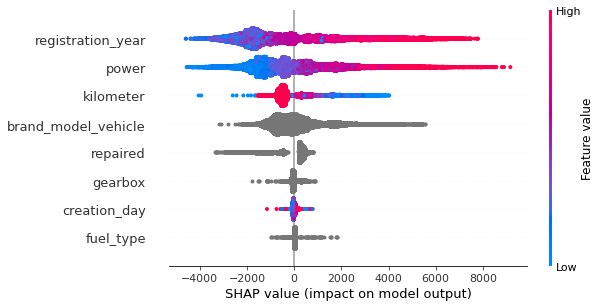

In [54]:
best_model = randomized_search_ctb.best_estimator_.named_steps['models']

explainer = shap.TreeExplainer(best_model)
shap_values = explainer(X_test)

shap.plots.beeswarm(shap_values) 

<hr>

По графику фидно, что топ-4 признака, вносящие наибольший вклад:

 - год регистрации автомобиля;
 - мощность;
 - километраж;
 - бренд / марка / тип кузова автомобиля.
 
Таким образом к высокой прогнозной стоимости автомобиля будут склонять:

 - высокие значения года регистрации и высокая мощность автомобиля;
 - низкие значения пробега;

<hr>

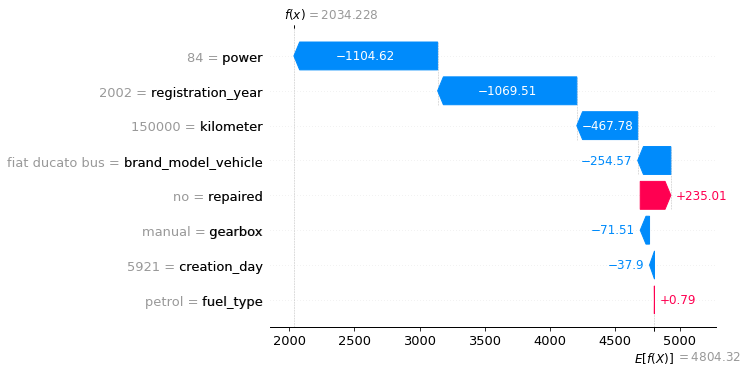

In [55]:
shap.plots.waterfall(shap_values[5]) 

<hr>

<p style='text-align: justify;'>На графике выше видно влияние признаков для одного конкретного наблюдения из выборки. По графику видно, что к низкой прогнознеой стоимости больше всего приводит низкое значение мощности автомобиля (84 л.с.) и давний год регистрации (2002 г.), также весомый вклад в занижение вносит высокое значение пробега (150 т. км).</p>

<hr>

<hr>
<font size=4.5><b>Итоги раздела:</b></font>

<p style='text-align: justify;'>Качество модели <b>CatBoostRegressor</b> на тестовых данных, равное 1853.6, получилось близким к качеству при валидации, равному 1871.7. Модель не переобучилась и хорошо прогнозирует неизвестные данные.</p>

<hr>

<a id='step_5'></a>

## Общий вывод

В данной работе был проведен анализ данных об автомобилях для сервиса по продаже автомобилей с пробегом «Не бит, не крашен», который разрабатывает приложение, чтобы привлечь новых клиентов.

<p style='text-align: justify;'>Сначала были загружены данные. В получившемся фрйме содержится 354,369 строк и 16 столбцов. Данные соответствуют описанию. В столбцах <i>VehicleType</i>, <i>Gearbox</i>, <i>Model</i>, <i>FuelType</i> и <i>Repaired</i> присутствуют пропущенные значения, образовавшиеся, скорее всего, на этапе сбора информации. Данные представлены типами <i><font color='purple'>int</font></i> и <i><font color='purple'>str</font></i>.</p>

<p style='text-align: justify;'>Далее была проведена предобработка данных.<br><br>
Были изменены названия столбцов в соответствии с форматом snake_case. Столбцы с информацией о датах были приведены к типу данных <i>datetime.</i><br><br>
Часть пропущенных значений в столбцах <i>vehicle_type</i>, <i>gearbox</i> и <i>fuel_type</i> была восстановленна по наиболее часто встречающимся значениям для соответствующей модели автомобиля, строки с пропусками в столбцах <i>repaired</i> и <i>model</i> были удалены.<br><br>
В типе топлива присутствовали значения <i>petrol</i> и <i>gasoline</i>, которые являются "бензином", они были приведены к одному значению <i>petrol</i>.<br><br>
Для категориальных и количественных параметров были построенны диаграммы размаха, на них также была отображена зависимость целевого признака. По построенным графикам были сделаны следующие выводы:</p>

<p style='text-align: justify;'> - В выборке большая часть машин продается за небольшую стоимость. График распределения стоимости имеет гиперболический вид.<br>
 - Большинство машин стоимостью 2 тысячи и менее были зарегистрированы до 2005 года, часть "дешевых" машин было зарегистрировано после 2015 года. В промежуток 2005 - 2015 регистрировались в основном машины стоимостью от 2 тысяч евро. График имеет вид нормального распределения.<br>
 - Машины с мощностью более 200 лошадиных сил стоят в основном более 6.5 тысяч евро. График имеет вид нормального распределения.<br>
 - Параметр "месяц регистрации автомобиля" принимает значение 0, эта ошибка была оставлена без изменений, потому что данный признак не будет учавствовать в обучении.<br>
 - В выборке все значения параметра "количество фотографий автомобиля" равны нулю, этот признак является неинформативным.<br>
 - Параметр "почтовый индекс владельца анкеты" может косвено указывать на город, в котором продается автомобиль, но это не должно влиять на формирование цены.<br>
 - Явной зависимости целевого признака от категориальных параметров <u>по графикам</u> не наблюдается.</p>
 
<p style='text-align: justify;'>В процессе построения графиков, была удалена часть строк с аномальными значениями параметров.</p>

<p style='text-align: justify;'>Далее была построена матрица корреляции Фи, по коэффициентам корреляции была обнаружена мультиколлиниарность. Для ее устранения признаки <i>model</i>, <i>vehicle_type</i> и <i>brand</i> были объединены в один признак <i>brand_model_vehicle</i>. Также был добавлен признак <i>creation_day</i>, в котором содержится информация о количестве дней, прошедших с 1 января 2000 года до момента выставления объявления о продаже, таким образом признак <i>date_created</i> был приведен к числовому типу данных.<br><br>По матрице не наблюдается корреляция между целевым признаком и новым признаком <i>creation_day</i>, но этот признак был сохранен для обучения с поправкой на текущую экономическую ситуацию, в 2015-2016 разница в стоимости одного и того же автомобиля, возможно, была не большой, но, например, в 2021-2022 годах, эта разница уже была существенной.<br><br>Столбцы с числовыми данными были приведены к типу данных меньшего размера для ускорения работы с данными.</p>

Для обучения будут использоваться следующие признаки:

 - <b>registration_year</b> - год регистрации автомобиля;
 - <b>gearbox</b> - тип коробки передач;
 - <b>power</b> - мощность (л. с.);
 - <b>kilometer</b> - пробег (км);
 - <b>fuel_type</b> - тип топлива;
 - <b>repaired</b> - была машина в ремонте или нет;
 - <b>brand_model_vehicle</b> - информация о марке, модели и типе кузова автомобиля;
 - <b>creation_day</b> - количество дней с 1 января 2000 года до дня, когда объявление о продаже было выставлено;

<p style='text-align: justify;'>После этого были подготовленны данные для дальнейшего обучения моделей.<br><br>Данные разбиты на тренировочную и тестовую выборки в соотношении 75/25.<br><br><i>Для модели DecisionTreeRegressor:<br></i>Создан пайплайн для кодирования категориальных признаков с помощью кодировщика <i>OrdinalEncoder</i>. Собран полный пайплайн для выполнения обработки значений и передачи их в модели.<br><br><i>Для моделей CatBoostRegressor и LGBMRegressor:</i><br>Обработка категориальных данных производится с помощью встроенных инструментов в модели.<br><br>Определена метрика RMSE, которая будет определять качество моделей при обучении и итоговое качество модели. Для каждой модели определен объект кросс-валидации <i>RandomizedSearchCV</i> с помощью которого будут обучаться модели.</p>

<p style='text-align: justify;'>Для каждой модели был проведен анализ остатков, в результате которого было выявлено:</p>

 - Распределение остатков всех моделей не смещены относительно нуля, значит модель в среднем не завышает и не занижает стоимость. 
 - По дисперсии модели DecisionTreeRegressor можно сказать, что при низких значениях предсказанной стоимости, модель занижает ее значение, а при высоких значениях предсказанной стоимости, модель завышает ее. 
 - По дисперсии моделей LGBMRegressor и CatBoostRegressor можно сказать, что модели также занижают значения при низкой предсказанной стоимости и завышают при высокой, но при этом влияние ошибок меньше чем у модели DecisionTreeRegressor.
 
Характеристики модели <b>DecisionTreeRegressor</b>:
<br>Время обучения модели: ~20 секунд;
<br>Время предсказания модели: ~200 млс;
<br>Качество при валидации: 2264.2;

Характеристики модели <b>LGBMRegressor</b>:
<br>Время обучения модели: ~10 минут;
<br>Время предсказания модели: ~7 с;
<br>Качество при валидации: 1653.2;

Характеристики модели <b>CatBoostRegressor</b>:
<br>Время обучения модели: ~1 минута 30 секунд;
<br>Время предсказания модели: ~50 млс;
<br>Качество при валидации: 1871.0;

<p style='text-align: justify;'>По критериям: качество предсказания, время обучения модели и время предсказания модели, лучшей моделью является <b>CatBoostRegressor</b>, т.к. она сочетает низкоевремя обчуения и предсказания при достаточно высоком качестве. Будем использовать ее для предсказания на тестовой выборке. Все модели соответствуют требованию: "Значение метрики RMSE должно быть меньше 2500".</p>

<p style='text-align: justify;'>Качество модели <b>CatBoostRegressor</b> на тестовых данных, равное 1853.6, получилось близким к качеству при валидации, равному 1871.0. Модель не переобучилась и хорошо прогнозирует неизвестные данные.<br><br>Также для модели проведен анализ важности признаков, наиболее значимыми признаками являются:</p>

 - год регистрации автомобиля;
 - мощность;
 - километраж;
 - бренд / марка / тип кузова автомобиля.
 
К высокой прогнозной стоимости автомобиля будут склонять:

 - высокие значения года регистрации и высокая мощность автомобиля;
 - низкие значения пробега;

